<a href="https://colab.research.google.com/github/mathiasskauge/ML_assignement/blob/main/ML_assignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Land Use and Land Cover Classification Using Sentinel-2 Data**

### MS Interview Task, Dec 2023 - Mathias Skauge Larsen

### Objective:
This task of the assignment is to perform land use and land cover classification using Sentinel-2 satellite imagery. It involves a series of steps, starting from dataset acquisition to the implementation of a deep learning-based classification model, followed by a thorough analysis and visualization of the results.

To recreate the results I got in this assignment, run each cell of the notebook in order.

# Step 1 - Downloading and visualizing the dataset

Step 1 of this assignement is to access and download the EuroSat dataset, which is available via Zenodo. (References at the end of the notebook). I opted to use Google Colab to create my notebook since I might want the extra computational power when training my model, and its a good opportunity for me to get familiar with the tool. I also have chosen to use the RGB version of the dataset, which includes the optical R, G and B frequency bands encoded as JPEG images.


I then downloaded the data to my local machine, and then added the zip-file to my Google Drive, which lets me access the dataset using the drive.mount() function.


### Import the essential libraries

In [ ]:
#Libraries for handling files and the drive
from google.colab import drive
import zipfile
import os

# Tensorflow for building the model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

#Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Sklearn for confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix

#Seed for fixing random states
seed = 123

In [ ]:
#Mounting my Google Drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Studies/MachineLearning/EuroSAT_RGB.zip'

extract_path = '/content/dataset'

#Extracting the dataset from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#The EuroSAT_RGB_split file explained in the splitting data section
print("Files extracted:", os.listdir(extract_path))

Mounted at /content/drive
Files extracted: ['EuroSAT_RGB']


## Preprocessing

I then load the EuroSAT RGB dataset using TensorFlow's tf.keras.preprocessing.image_dataset_from_directory method. I set the batch size to 32, meaning our dataset will yield 32 images at a time during training. Each image is size 64x64 pixels. The labels='inferred' parameter labels the images based on the directory structure, since each class of images are placed in their own folder. The result is a tf.data.Dataset object, which is an iterable format for training machine learning models using tensorflow.

In [ ]:
#Loading the dataset for visialization
dataset_url = '/content/dataset/EuroSAT_RGB'
batch_size = 32
img_height = 64
img_width = 64

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url,
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
    )

NotFoundError: Could not find directory /content/dataset/EuroSAT_RGB

## Visualizing

Now that the dataset is loaded I will use matplotlib to visualize my dataset. For this step I want to have a look at what the pictures actually look like, and also the class distribution of the data. By using the preprocessing tool form tensorflow I can see that the data consists of 27000 files belonging to 10 classes, but they are not necessarily evenly distributed.

I decided to have a look at one picture from each class first:

Copying files: 17748 files [19:19, 15.31 files/s]  
Copying files: 10819 files [19:34,  9.21 files/s]  


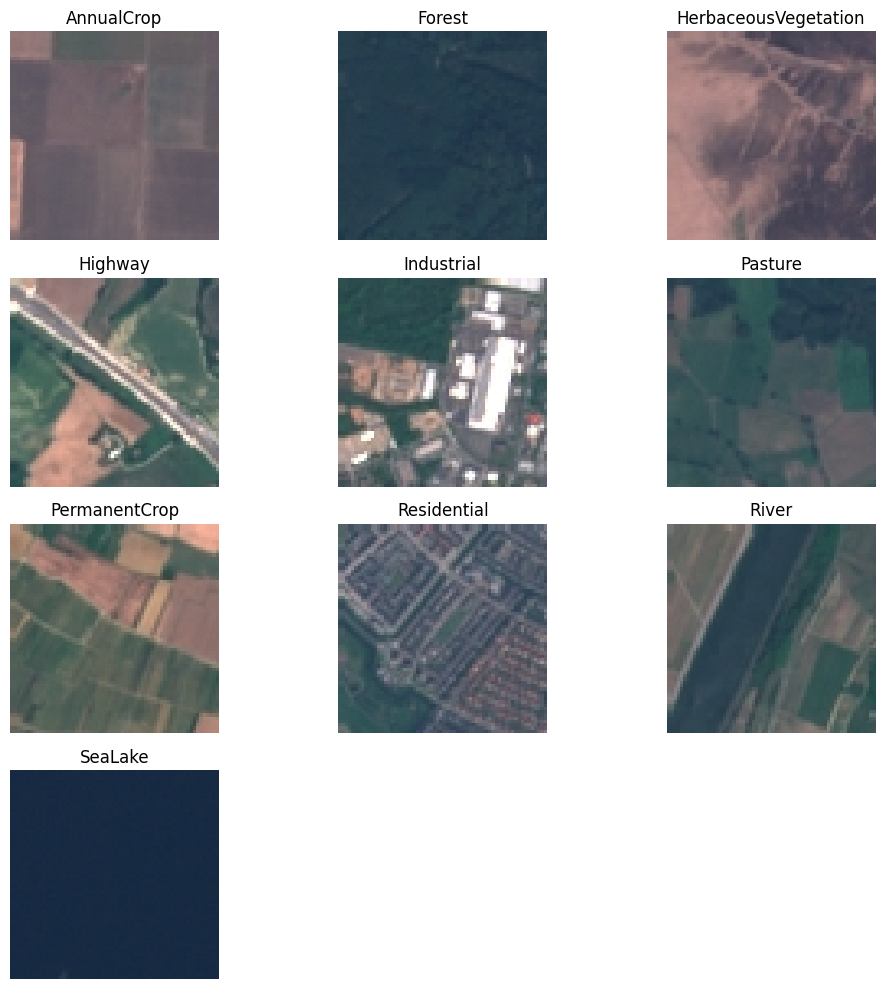

In [ ]:
#Using matplotlib to plot one image from each class
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
#Loop through class names
for i, class_name in enumerate(class_names):
    for images, labels in dataset:
        #Loop through batches, then separate images in the inner loop
        for img, lbl in zip(images, labels):
            if lbl.numpy() == i:
                ax = plt.subplot(4, 3, i + 1)
                plt.imshow(img.numpy().astype("uint8"))
                plt.title(class_names[lbl])
                plt.axis("off")
                break
        if lbl.numpy() == i:
            break

plt.tight_layout()
plt.show()

## Class distribution

I then create a chart over the class distribution in the dataset. As we know the dataset contains 27000 images, so there should be plenty of images in each class. If the dataset is very impbalanced, this might induce bias to our model, and we might want to do some pre-processing steps like over/under sampling or chose a different evaluation metric.

Class 'AnnualCrop': 3000 images
Class 'Forest': 3000 images
Class 'HerbaceousVegetation': 3000 images
Class 'Highway': 2500 images
Class 'Industrial': 2500 images
Class 'Pasture': 2000 images
Class 'PermanentCrop': 2500 images
Class 'Residential': 3000 images
Class 'River': 2500 images
Class 'SeaLake': 3000 images


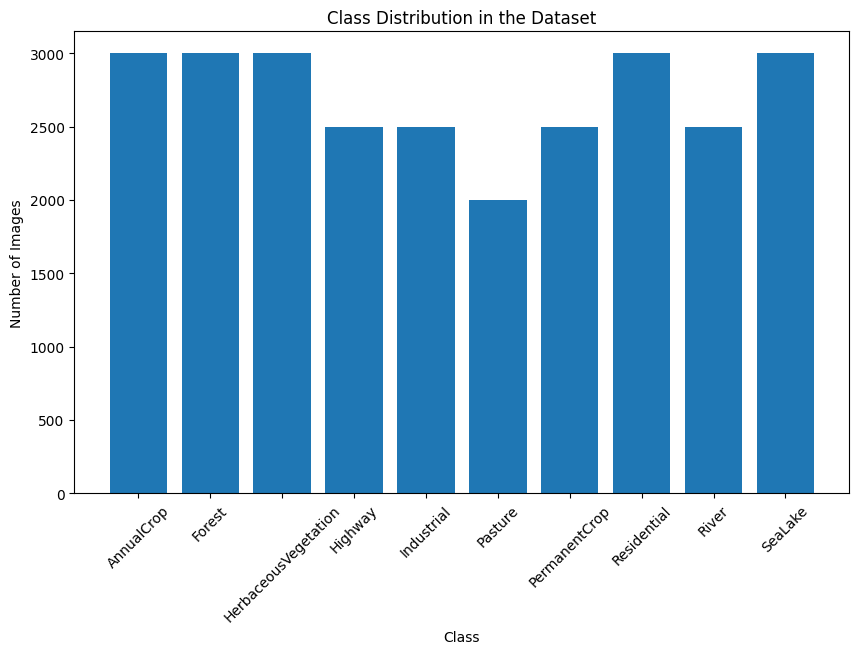

In [ ]:
#Visualizing and printing class distribution

class_names = dataset.class_names
class_counts = {class_name: 0 for class_name in class_names}

#Count the number of images in each class
for images, labels in dataset:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

#Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

#Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

## Observations

Looking at images:

By looking at the images from the different classes, we can see what the the different classes are meant to represent, and where the model might struggle to differentiate two classes. SeaLake and Forest both have a dark colors with not to much happening in them, so this might be a challenge. AnnualCrop and PermanentCrop also share some of the same features, so this might be challenging for the model as well.

Class distribution:

As the chart shows, there are some imbalance in the data. The "Pasture"-class has the least images, with 2000, 4 of the others have 2500, and the last 5 have 3000 images. While this is some imbalance, there are still alot of images even in the classes with the least images. I wont do any steps now to balance the dataset even further in this case.

# Step 2 - Implement a deep learning model

## Model selection

To solve the image classification task, I have tried to use the knowledge I have about ML from before, as well as reading about what the state-of-the-art solutions. The best models for image classification today are the Convolutional Neural Networks (CNNs). By stacking multiple convolutional and pooling layers, CNNs can learn increasingly complex features, leading to high accuracy in tasks like this.

Some of the most commonly used CNN models are VGG, ResNet, Inception and Xception. I first wanted to implement one of these, but since I am yet to take the deep learning course, I didn't want to find some code on the internet that I dont really understand.

I have therefore opted to implement a simpler version of a CNN, where I can understand to greater extend whats happening. My model will follow the CNN-tutorial given by Tensorflow, that contains a stack of three Conv2D layers and two MaxPooling2D layers, as well as two Dense layers.



## Splitting the data

### Splitting test-data into separate folder

I then wanted to split the data into training, validation and test data, opting for a 60-20-20 split. I soon encountered a problem with the ImageDataGenerator from Keras, that it only let me split the data twofold and not threefold. To solve this I used the splitfolders function below, to create a separate path to the test data. This ensures that the test data remains unseen until the end, and the splitting is also random so it wont infer bias.

In [ ]:
import splitfolders

input_folder = '/content/dataset/EuroSAT_RGB'
output_folder = '/content/dataset/EuroSAT_RGB_split'

#Split with a ratio, 80% training+validation and 20% test
splitfolders.ratio(input_folder, output=output_folder, seed=seed, ratio=(.8, .2))

Copying files: 27000 files [00:16, 1597.03 files/s]


### Using ImageDataGenerator

I then create a datagen object, which I can use the flow_from_directory call on to create my datasets. I here give 0.25 as my validation split, but thats only because I've already splitted out my test-data, and 0.25 * 0.8 = 0.2. I also rescale the feature values, to be between 0 and 1 as its benefitial to the model.

In [ ]:
validation_split=0.25
rescale=1.0/255

#Creating ImageDataGenerator object
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)

train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory="/content/dataset/EuroSAT_RGB_split/train",
                                           shuffle=True,
                                           seed=seed,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

val_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory="/content/dataset/EuroSAT_RGB_split/train",
                                           shuffle=True,
                                           seed=seed,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')


Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


## Building my CNN model

In the next cell I build my CNN model. The model consist of a few different layers as mentioned:

The first is a convolutional layer consisting of 32 filters, each 3x3 in size, utilizing the 'ReLU' activation function known for its effectiveness in pattern recognition. This was followed by a max pooling layer with a 2x2 window, aimed at reducing the image dimensions while retaining essential features.

Then a second convolutional layer with 64 filters was introduced, enabling the detection of more intricate features. This layer was succeeded by another 2x2 max pooling layer.

The model's final convolutional layer, equipped with another set of 64 filters, prepared the data for the transition to denser layers. A flattening layer then converted the 2D feature maps into a 1D vector, leading into a fully connected dense layer with 64 neurons.

The last part is a dense layer with 10 units, each corresponding to a class in the classification task.




In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

## Fitting my model

Next step is compiling and training the model, followed by saving it for future use.

To start, I compiled the model using the Adam optimizer, a popular choice for its efficiency in handling sparse gradients on noisy problems. The loss function was set to CategoricalCrossentropy, suitable for multi-class classification tasks. Importantly, I set from_logits=True because the final layer of my model was a linear layer (without a softmax activation), and this setting ensures the loss function internally applies the softmax. The metric chosen for evaluation was 'accuracy', providing a clear and interpretable measure of the model's performance.

Here I would like to say that I should to some more hyperparameter search, but I just didn't have time to train more than one model this time.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Fitting the model with 10 epochs, takes about 22 minutes
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


model_dir = '/content/model'
# Create the directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# Save your model
model.save(os.path.join(model_dir, 'my_cnn'))

Epoch 1/10
507/507 [==============================] - 131s 256ms/step - loss: 0.7879 - accuracy: 0.7159 - val_loss: 0.7015 - val_accuracy: 0.7396
Epoch 2/10
507/507 [==============================] - 128s 253ms/step - loss: 0.6732 - accuracy: 0.7546 - val_loss: 0.6334 - val_accuracy: 0.7687
Epoch 3/10
507/507 [==============================] - 120s 237ms/step - loss: 0.6130 - accuracy: 0.7776 - val_loss: 0.5977 - val_accuracy: 0.7772
Epoch 4/10
507/507 [==============================] - 132s 260ms/step - loss: 0.5523 - accuracy: 0.8016 - val_loss: 0.5337 - val_accuracy: 0.8115
Epoch 5/10
507/507 [==============================] - 131s 259ms/step - loss: 0.5110 - accuracy: 0.8158 - val_loss: 0.4971 - val_accuracy: 0.8241
Epoch 6/10
507/507 [==============================] - 124s 244ms/step - loss: 0.4496 - accuracy: 0.8391 - val_loss: 0.5923 - val_accuracy: 0.7922
Epoch 7/10
507/507 [==============================] - 123s 242ms/step - loss: 0.4132 - accuracy: 0.8538 - val_loss: 0.4903 -

# Step 3 Present and discuss the outcomes

I then want to have a look at the result and how my model performs. To do this I will have a look at plots for the training and validation accuracy, as well as training and validation loss. I will then test my model on unseen test data.

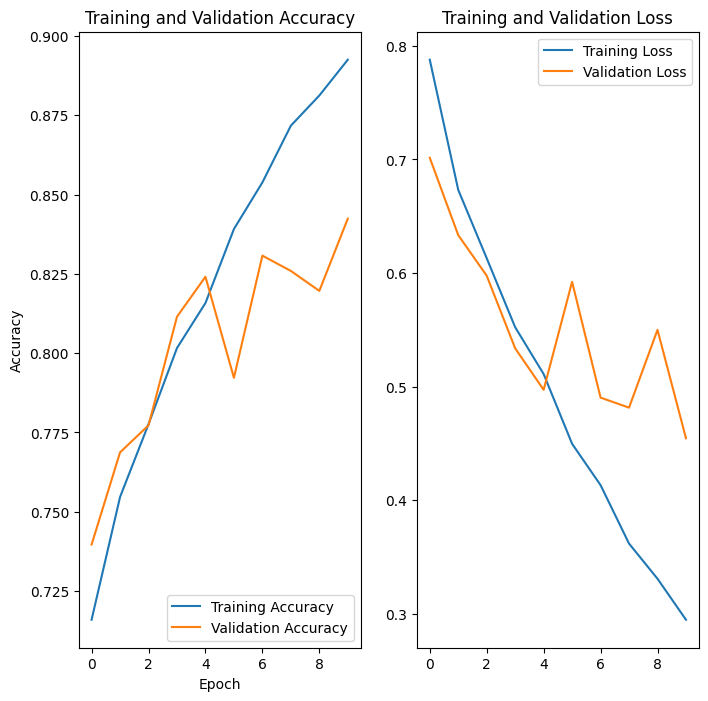

In [ ]:
#Creating plots for training and validation
epochs = 10

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observations

Results after 10 epochs of fitting:

Training accuracy = 0.8925
Training loss = 0.2947

Validation accuracy = 0.8424
Validation loss = 0.4545

Training and Validation Accuracy:
The training accuracy is steadily increasing, which indicates that the model is learning and improving its performance on the training set over time. However, the validation accuracy is not improving at the same rate and exhibits some fluctuations, which might suggest that the model is not generalizing as well to new, unseen data. This could be a sign of overfitting, where the model performs well on training data but not as well on data it hasn't seen before.

Training and Validation Loss:
The training loss is decreasing, which is expected as the model learns from the training data. The validation loss, on the other hand, is not showing a consistent decrease. It decreases initially but then shows volatility and an upward trend in the latter epochs. This again points towards possible overfitting, as the model is becoming more tailored to the training data and potentially less able to predict accurately on the validation set.

## Predicting unseen data (test data)

I then wanted to predict on unseen test data, and create a Confusion Matrix and a Classification Report:

In [ ]:
#Loading the test data
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/EuroSAT_RGB_split/val",
    labels='inferred',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
    )

# Add the rescaling layer
rescale_layer = Rescaling(1./255)
test_dataset = test_dataset.map(lambda x, y: (rescale_layer(x), y))

Found 5400 files belonging to 10 classes.


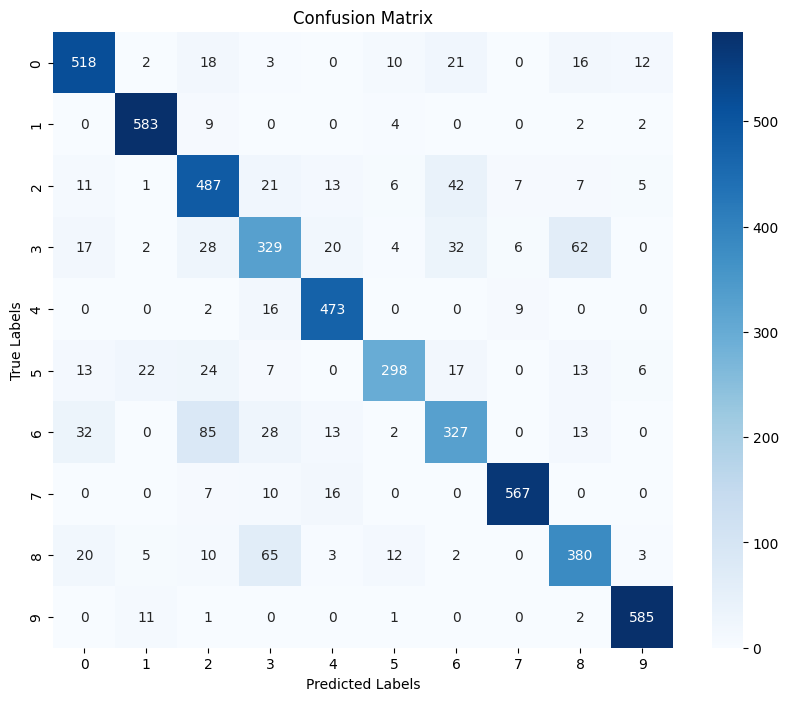

                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.86      0.86       600
              Forest       0.93      0.97      0.95       600
HerbaceousVegetation       0.73      0.81      0.77       600
             Highway       0.69      0.66      0.67       500
          Industrial       0.88      0.95      0.91       500
             Pasture       0.88      0.74      0.81       400
       PermanentCrop       0.74      0.65      0.70       500
         Residential       0.96      0.94      0.95       600
               River       0.77      0.76      0.76       500
             SeaLake       0.95      0.97      0.96       600

            accuracy                           0.84      5400
           macro avg       0.84      0.83      0.83      5400
        weighted avg       0.84      0.84      0.84      5400



In [ ]:
#Load the model
model = tf.keras.models.load_model('/content/model/my_cnn')

# Make predictions
predictions = []
true_labels = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    predictions.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

#Visualization of Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_names = list(train_dataset.class_indices.keys())  # Adjust if you have a specific list of class names
print(classification_report(true_labels, predictions, target_names=class_names))

## Results

Overall Accuracy: 0.84, with the model correctly predicting the class 84% of the time across all classes.


Macro Average F1-score: 0.83, averaging the F1-scores of all classes without considering the number of instances for each class.


Weighted Average F1-score: 0.84, averaging the F1-scores for each class, taking the support into account, which compensates for class imbalance.

## Conclusion

As shown by the confusion matrix, the models performs best on Forest, PermanentCrop og SeaLake, and worst on HerbaceousVegetation vs. PermanentCrop and Highway vs. River. This is maybe to be expected had I thought about it, since rivers and highways have a similar shape for example.

The model made only decent accuracy (0.84), but it might be expected as I didnt create the most complicated model for this task. Anyway it was a fun experience trying to create a CNN, and I at least learned alot. Next time I will focus on creating a better model, and definitly taking time to do hyperparameter tuning as well.

# References:

### TensorFlow CNN toturial:

https://www.tensorflow.org/tutorials/images/cnn

### About CNNS:

https://datagen.tech/guides/computer-vision/resnet-50/

### Most used CNNs

https://towardsdatascience.com/convolutional-neural-networks-most-common-architectures-6a2b5d22479d

### The data:

Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing.

Helber, P., Bischke, B., Dengel, A., & Borth, D. (2018). Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 204-207).

### Download link can be found at:

https://github.com/phelber/EuroSAT
